In [3]:
import sys
sys.path.append("/home/ricky/Documents/from_work/git/NMR_FF_tools/relaxation_times/")
sys.path.insert(1, '/home/ricky/Documents/from_work/git/charged_molecules_binding/simulations_list/')

sys.path.append("../")

import numpy as np
#import relaxation_times as rt
#import manage_files as mf
#*import plotting as pt
import matplotlib.pyplot as plt


from scipy.optimize import minimize

import SRT_optimization as srt

import gc
gc.collect()

0

In [1]:
pwd

'/home/ricky/Documents/from_work/git/EffectiveTimes_R2/work_in_progress/18-linear_fit'

In [10]:
gammaH=267.513*10**6;
gammaN=-27.166*10**6;

fields=[300,360,400,500,600,700,720,750,800,850,900,950,1000,1200,1500]
magn_field_MHz=850 # for values in MHz

save_labels=["small_peptides",
       "peptides_SDSmicelles",
       "Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]


systems={}
for magn_field_MHz in fields:
    magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6

    # data is saved in the form [[effTimes],[R1],[R2],[hetNOE]]

    systems[magn_field_MHz]={}
    for system in save_labels:
        systems[magn_field_MHz][system]=np.loadtxt("../01_main_figure/simulation_SRT_vs_effTime/"+system+"_"+str(magn_field_MHz)+".dat")
    
    

In [11]:
for magn_field_MHz in fields:
    all_x=[]
    all_y=[]
    for sys in systems[magn_field_MHz]:
        all_x+=list(systems[magn_field_MHz][sys][2])
        all_y+=list(systems[magn_field_MHz][sys][0])

    fit=np.polyfit(all_x,all_y,1)
    
    print(magn_field_MHz,fit[0],fit[1])

300 0.8505023649181864 -1.5219959968828325
360 0.8300269778154261 -1.2551073762259222
400 0.8124356874290468 -1.1076984315383367
500 0.7613868702880092 -0.8274040121950546
600 0.7059576461936383 -0.6379466290115611
700 0.6500125444131274 -0.5064302855306538
720 0.6389695082501095 -0.4851016188448279
750 0.622559480409282 -0.4556056405860946
800 0.5957079472145473 -0.41225705296968135
850 0.5695941578523225 -0.3750203408164195
900 0.5443193484860949 -0.3428182047150589
950 0.5199554876718089 -0.31479394431780483
1000 0.4965500962393556 -0.2902612990428297
1200 0.41282863208012954 -0.21740008839698594
1500 0.3151763668040663 -0.15293216535010465


In [40]:
def getSRT(fast,slow,times,magnetic_field):

    x=np.logspace((fast),(slow),times) # x-akselin rajat

    T1s=[]
    T2s=[]
    NOEs=[]

    for b in x:
        T1,T2,NOE=rt.get_relaxation_N(magnetic_field,[1],[b],0)
        T1s.append(T1)
        T2s.append(T2)
        NOEs.append(NOE)

    T1s=np.array(T1s)
    T2s=np.array(T2s)
    NOEs=np.array(NOEs)
    
    return T1s, T2s, NOEs, x

T2_threshold=0.0001
NOE_threshold=0.0001

def get_errors_and_differences(T2_threshold,NOE_threshold,magnetic_field,timescales_yamls):
    """calculates differences and errors in effective times.
     differences_T1 = simulation effTime - effTime from 1 timescale T1 equation 
                                               (not well defined, not well developed)
     differences_T2 = simulation effTime - effTime from 1 timescale T2 equation
     differences_NOE = simulation effTime - effTime from 1 timescale NOE equation
     
     for T2, hetNOE, therholds are used in itteration in the search of the correct solution
     when found T2, hetNOE are within this thershold from the calculated values from simulations,
     effective time is calculated as a linear approximation between the first smaller and 
     the first bigger effective time
     """


    differences_T1=[]
    errors_T1=[]
    differences_T2=[]
    errors_T2=[]
    differences_NOE=[]
    errors_NOE=[]

    for i,timescales in enumerate(timescales_yamls):

        for j,sim in enumerate(timescales):  

            #check if timesales exist
            for ana2 in timescales[sim]:
                info=timescales[sim][ana2]["info"]
                #select the analysis that we used
                if (info["04_smallest_corr_time_[s]"]==10**(-12) and
                    info["05_biggest_corr_time_[s]"]==10**(-7) and
                    info["03_N_exp_to_fit"]==100 and
                    info["00_nuclei"]=='15N'):

                    for bond in timescales[sim][ana2]["results"]["Coeff"]:
                        if timescales[sim][ana2]["results"]["Coeff"][bond][-1]>0:
                            timescales[sim][ana2]["results"]["Coeff"][bond][-1]=0

                        coeff=timescales[sim][ana2]["results"]["Coeff"][bond]
                        ctime=timescales[sim][ana2]["results"]["Ctime"]
                        effTime=sum(t*k for t,k in zip(coeff,ctime))

                        
                        T1s, T2s, NOEs, x = getSRT(-20,-3,10,magnetic_field)
                        T1,T2,NOE=rt.get_relaxation_N(magnetic_field,coeff,ctime,0)
                        minT1=list(np.absolute(T1s-T1))
                        effT1=x[minT1.index(min(np.absolute(minT1)))]


                        
                        minT2=list(np.absolute(T2s-T2))
                        T2assign=T2s[minT2.index(min(np.absolute(minT2)))]

                        l=0
                        while np.absolute(T2assign-T2)>T2_threshold:
                            l+=1
                            #print("begin: loop",l,", T2ass:",T2assign, "T2 diff:",np.absolute(T2assign-T2))
                            if T2assign>T2:
                                fast=np.log10(x[minT2.index(min(np.absolute(minT2)))])
                                slow=np.log10(x[minT2.index(min(np.absolute(minT2)))+1])
                                T1s, T2s, NOEs, x = getSRT(fast,slow,10,magnetic_field)
                                #print("slow:",slow,", fast:",fast)
                            else:
                                fast=np.log10(x[minT2.index(min(np.absolute(minT2)))-1])
                                slow=np.log10(x[minT2.index(min(np.absolute(minT2)))])
                                T1s, T2s, NOEs, x = getSRT(fast,slow,10,magnetic_field)
                                #print("slow:",slow,", fast:",fast)

                            minT2=list(np.absolute(T2s-T2))
                            T2assign=T2s[minT2.index(min(np.absolute(minT2)))]
                            #print("end: loop",l,", T2ass:",T2assign, "T2 diff:",np.absolute(T2assign-T2),"\n")

                        #
                        #print("it took",l,"loops")
                        if T2assign>T2:
                            T2sm=T2s[minT2.index(min(np.absolute(minT2)))+1]
                            T2_borders_diff=T2assign-T2sm
                            T2_diff_from_small=T2-T2sm
                            factor=T2_diff_from_small/T2_borders_diff
                            effT2=x[minT2.index(min(np.absolute(minT2)))+1]-factor*(x[minT2.index(min(np.absolute(minT2)))+1]-x[minT2.index(min(np.absolute(minT2)))])
                        else:
                            T2b=T2s[minT2.index(min(np.absolute(minT2)))-1]
                            T2_borders_diff=T2b-T2assign
                            T2_diff_from_small=T2assign-T2
                            factor=T2_diff_from_small/T2_borders_diff
                            effT2=x[minT2.index(min(np.absolute(minT2)))]-factor*(x[minT2.index(min(np.absolute(minT2)))]-x[minT2.index(min(np.absolute(minT2)))-1])


                        T1s, T2s, NOEs, x = getSRT(-20,-3,10,magnetic_field)
                        minNOE=list(np.absolute(NOEs-NOE))
                        NOEassign=NOEs[minNOE.index(min(np.absolute(minNOE)))]

                        l=0
                        while np.absolute(NOEassign-NOE)>NOE_threshold:
                            l+=1
                            #print("begin: loop",l,", NOEass:",NOEassign, "NOE diff:",np.absolute(NOEassign-NOE))
                            if NOEassign>NOE:
                                fast=np.log10(x[minNOE.index(min(np.absolute(minNOE)))-1])
                                slow=np.log10(x[minNOE.index(min(np.absolute(minNOE)))])
                                T1s, T2s, NOEs, x = getSRT(fast,slow,10,magnetic_field)
                                #print("slow:",slow,", fast:",fast)
                            else:
                                fast=np.log10(x[minNOE.index(min(np.absolute(minNOE)))])
                                slow=np.log10(x[minNOE.index(min(np.absolute(minNOE)))+1])
                                T1s, T2s, NOEs, x = getSRT(fast,slow,10,magnetic_field)

                            minNOE=list(np.absolute(NOEs-NOE))
                            NOEassign=NOEs[minNOE.index(min(np.absolute(minNOE)))]
                            #print("end: loop",l,", T2ass:",NOEassign, "T2 diff:",np.absolute(NOEassign-NOE),"\n")

                        #print("it took",l,"loops")

                        if NOEassign>NOE:
                            NOEsm=NOEs[minNOE.index(min(np.absolute(minNOE)))-1]
                            NOE_borders_diff=NOEassign-NOEsm
                            NOE_diff_from_small=NOE-NOEsm
                            factor=NOE_diff_from_small/NOE_borders_diff
                            effNOE=x[minNOE.index(min(np.absolute(minNOE)))-1]+factor*(x[minNOE.index(min(np.absolute(minNOE)))-1]-x[minNOE.index(min(np.absolute(minNOE)))])
                        else:
                            NOEb=NOEs[minNOE.index(min(np.absolute(minNOE)))+1]
                            NOE_borders_diff=NOEb-NOEassign
                            NOE_diff_from_small=NOEassign-NOE
                            factor=NOE_diff_from_small/NOE_borders_diff
                            effNOE=x[minNOE.index(min(np.absolute(minNOE)))]+factor*(x[minNOE.index(min(np.absolute(minNOE)))]-x[minNOE.index(min(np.absolute(minNOE)))+1])




                        differences_T1.append(effTime-effT1)
                        differences_T2.append(effTime-effT2)
                        differences_NOE.append(effTime-effNOE)

                        errors_T1.append(np.absolute(effTime-effT1)/effTime)
                        errors_T2.append(np.absolute(effTime-effT2)/effTime)
                        errors_NOE.append(np.absolute(effTime-effNOE)/effTime)
    return differences_T1, differences_T2, differences_NOE, errors_T1, errors_T2, errors_NOE


def get_differences_poly1d(magn_field_MHz,timescales_yamls):
    """calculates differences 
     differences_T2 = simulation effTime - effTime from 1 timescale T2 equation
     uses poly1d handeling 
     """
    
    magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
    differences_T2=[]
    
    for i,timescales in enumerate(timescales_yamls):

        for j,sim in enumerate(timescales):  

            #check if timesales exist
            for ana2 in timescales[sim]:
                info=timescales[sim][ana2]["info"]
                #select the analysis that we used
                if (info["04_smallest_corr_time_[s]"]==10**(-12) and
                    info["05_biggest_corr_time_[s]"]==10**(-7) and
                    info["03_N_exp_to_fit"]==100 and
                    info["00_nuclei"]=='15N'):

                    for bond in timescales[sim][ana2]["results"]["Coeff"]:
                        if timescales[sim][ana2]["results"]["Coeff"][bond][-1]>0:
                            timescales[sim][ana2]["results"]["Coeff"][bond][-1]=0

                        coeff=timescales[sim][ana2]["results"]["Coeff"][bond]
                        ctime=timescales[sim][ana2]["results"]["Ctime"]
                        effTime=sum(t*k for t,k in zip(coeff,ctime))

                        
                        T1,T2,NOE=rt.get_relaxation_N(magnetic_field,coeff,ctime,0)
                        effT2=srt.find_tau_from_R2_np_poly1d(magn_field_MHz,1/T2)
                        
                        differences_T2.append(effTime-effT2)

    return  differences_T2


def get_differences_hyperbolic(magn_field_MHz,timescales_yamls):
    """calculates differences 
     differences_T2 = simulation effTime - effTime from hyperbolic approximation
     """
    
    magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
    differences_T2=[]
    
    for i,timescales in enumerate(timescales_yamls):

        for j,sim in enumerate(timescales):  

            #check if timesales exist
            for ana2 in timescales[sim]:
                info=timescales[sim][ana2]["info"]
                #select the analysis that we used
                if (info["04_smallest_corr_time_[s]"]==10**(-12) and
                    info["05_biggest_corr_time_[s]"]==10**(-7) and
                    info["03_N_exp_to_fit"]==100 and
                    info["00_nuclei"]=='15N'):

                    for bond in timescales[sim][ana2]["results"]["Coeff"]:
                        if timescales[sim][ana2]["results"]["Coeff"][bond][-1]>0:
                            timescales[sim][ana2]["results"]["Coeff"][bond][-1]=0

                        coeff=timescales[sim][ana2]["results"]["Coeff"][bond]
                        ctime=timescales[sim][ana2]["results"]["Ctime"]
                        effTime=sum(t*k for t,k in zip(coeff,ctime))

                        T1,T2,NOE=rt.get_relaxation_N(magnetic_field,coeff,ctime,0)
                        effT2=srt.find_tau_from_R2_hyperbolic_approximation(magn_field_MHz,1/T2)

                        
                        differences_T2.append(effTime-effT2)

    return  differences_T2
    
def get_differences_linear_fit(magn_field_MHz,systems):
    fit_equations={300:[0.8505023649181864, -1.5219959968828325],
                   360:[0.8300269778154261, -1.2551073762259222],
                   400:[0.8124356874290468, -1.1076984315383367],
                   500:[0.7613868702880092, -0.8274040121950546],
                   600:[0.7059576461936383, -0.6379466290115611],
                   700:[0.6500125444131274, -0.5064302855306538],
                   720:[0.6389695082501095, -0.4851016188448279],
                   750:[0.622559480409282, -0.4556056405860946],
                   800:[0.5957079472145473, -0.41225705296968135],
                   850:[0.5695941578523225, -0.3750203408164195],
                   900:[0.5443193484860949, -0.3428182047150589],
                   950:[0.5199554876718089, -0.31479394431780483],
                   1000:[0.4965500962393556, -0.2902612990428297],
                   1200:[0.41282863208012954, -0.21740008839698594],
                   1500:[0.3151763668040663, -0.15293216535010465]}
    
    magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
    differences_T2=[]
    
    for system in systems:
        #print(system)
        for i,effTime in enumerate(system[0]):
            R2=system[2][i]
            effT2=(fit_equations[magn_field_MHz][0]*(R2)+fit_equations[magn_field_MHz][1])
            
            differences_T2.append(effTime-effT2)

    return  differences_T2
    

In [17]:
for s in systems[850]:
    print(s)

small_peptides
peptides_SDSmicelles
Calmodulin
CDNF
EN2
musMANF
TonB


In [45]:
diffr={}
magn_fields_MHz=[400,600,850,1000,1200,1500]
for magn_field_MHz in magn_fields_MHz:

    differences_T2= get_differences_linear_fit(magn_field_MHz,[systems[magn_field_MHz]['peptides_SDSmicelles']])
    differences_T2_E = get_differences_linear_fit(magn_field_MHz,[systems[magn_field_MHz]['small_peptides']])
    differences_T2_A = get_differences_linear_fit(magn_field_MHz,[systems[magn_field_MHz]['Calmodulin'], 
                                                                  systems[magn_field_MHz]['CDNF'], 
                                                                  systems[magn_field_MHz]['EN2'], 
                                                                  systems[magn_field_MHz]['musMANF'], 
                                                                  systems[magn_field_MHz]['TonB']])

    diffr[magn_field_MHz]={}
    diffr[magn_field_MHz]["differences_T2"]=differences_T2
    diffr[magn_field_MHz]["differences_T2_E"]=differences_T2_E
    diffr[magn_field_MHz]["differences_T2_A"]=differences_T2_A


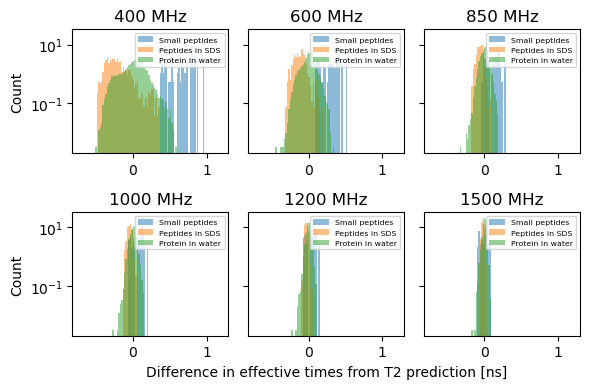

In [47]:
fig, ax = plt.subplots(2,3,sharey=True)
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


dens=True

magn_fields_MHz=[400,600,850,1000,1200,1500] # for values in MHz
for p,magn_field_MHz in enumerate(magn_fields_MHz):
    
    min_T2=min(diffr[magn_field_MHz]["differences_T2_A"])
    max_T2=max(diffr[magn_field_MHz]["differences_T2_A"])
    commBin=np.linspace(-0.72,1.2,100)

    dif_T2_E=np.array(diffr[magn_field_MHz]["differences_T2_E"])
    dif_T2=np.array(diffr[magn_field_MHz]["differences_T2"])
    dif_T2_A=np.array(diffr[magn_field_MHz]["differences_T2_A"])


    ax[p//3,p%3].hist(dif_T2_E,alpha=0.5,bins=commBin,label="Small peptides",density=dens)
    ax[p//3,p%3].hist(dif_T2,alpha=0.5,bins=commBin,label="Peptides in SDS",density=dens)
    ax[p//3,p%3].hist(dif_T2_A,alpha=0.5,bins=commBin,label="Protein in water",density=dens)
    
    ax[p//3,p%3].set_yscale("log")
    
    ax[p//3,p%3].set_title(str(magn_field_MHz)+" MHz")
    
    ax[p//3,p%3].legend(prop={"size":5.6})

    

ax[1,1].set_xlabel("Difference in effective times from T2 prediction [ns]")
ax[0,0].set_ylabel("Count")
ax[1,0].set_ylabel("Count")

plt.savefig("histogram_difference_eff_log_normalized_field_fit.pdf")

In [37]:
diffr

{400: {'differences_T2': [1.2384048259044047,
   2.8779022594865893,
   2.763335215935311,
   3.116780483806799,
   3.6089222348132766,
   3.5245368883970016,
   3.953156268829472,
   3.820687083688197,
   4.004056045233503,
   4.169583570568538,
   4.3131003454426615,
   4.221752301569171,
   4.172518663194777,
   4.310698860699395,
   4.097229999133227,
   4.0506896049960694,
   3.94727401164461,
   3.769553326739005,
   3.5974901958827195,
   3.3653632167359606,
   3.2117349818867282,
   2.049575580738251,
   2.243662416401838,
   3.620597607400687,
   3.9171341183892436,
   4.381024507209457,
   4.433524229792824,
   4.216414087348481,
   4.30343306044422,
   4.667408944653383,
   4.707517692634696,
   4.275729773833339,
   4.578897961426384,
   4.673364259755595,
   4.642496588502616,
   4.338261378123747,
   4.680440218171461,
   4.6414189659931395,
   4.341463843414317,
   4.422970310123171,
   4.6130385077826865,
   4.647656002643877,
   3.1299455171094994,
   2.879380839488797